# Naive Bayes Classification

This notebook develops the idea of case base classiication (cb-clf). This involves:
1. Identify sets of feature that provide good classification accuracy. There may be many.
1. Given a new feature vector, provide evidence for the difference classes to which it may belong.

A **feature** is an atribtue of the data, like a Gene. A feature set is a collection of genes.
We typically write this as Rv3246c+Rv3260c.

A **feature vector** is a set of features with a value assigned. We are dealing with trinary values: -1 (under expressed),
+1 (over expressed), 0 (otherwise).
We typically write this as
Rv3246c[-1]+Rv3260c[0].

A **case** is a feature vector that effectively distinguishes between expression states (classes).

Cases are obtained from decision trees by examining nodes to see if their *impurity* (class distinctions) are statistically
significant.

Decision trees are obtained by running the Random Forest Classsification Algorithm.
This is done separately for each expression state.
So, in our data, there are 6 sets of cases.

Classifications are evaluated for new gene expression data by:
* Setup
   1. Construct cases for each expression state.
   
* Evaluation of a data set
   1. Create trinary data
   1. For each expression state
      1. Find applicable cases
      1. Plot their significance level

## Imports

In [6]:
import init
import common.constants as cn
import common_python.constants as ccn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common_python.util import util

import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

%matplotlib inline

In [7]:
# File paths
REPO_PATH = util.findRepositoryRoot("xstate")
DATA_PATH = os.path.join(REPO_PATH, "data")
DF_X_PATH = os.path.join(DATA_PATH, "feature_values_regulators.csv")
DF_X_FULL_PATH = os.path.join(DATA_PATH, "feature_values.csv")
SER_Y_PATH = os.path.join(DATA_PATH, "class_values.csv")

In [8]:
# Training Data
DF_X = util.deserializePandas(DF_X_FULL_PATH)
SER_Y = util.deserializePandas(SER_Y_PATH)

In [9]:
# These are the "long" data that have individual replications, not averages. And, only using TFs.
STATES = SER_Y.unique()
FEATURES_NAMES = DF_X.columns.tolist()
NUM_TREE = 20000
PROVIDER = DataProvider()
PROVIDER.do()
SER_DESC = PROVIDER.df_go_terms.set_index(cn.GENE_ID)
SER_DESC = SER_DESC["GO_Term"]

In [15]:
# Combine 300 genes into 60 perfectly correlated genes
num_correlated_genes = sum([1 + c.count("--") for c in DF_X.columns if "-" in c])

## Data

1. The data consistent of individual replicas of read counts at 26 times.
1. Times are labelled with six states, as defined in ``STATE_DCT``.
1. Raw expression values of normalized w.r.t. time 0 (normal) and transformed as log2 so that there are
25 normalized times that are trinary values defined as:
   * -1 if < -1
   * 1 if > 1
   * 0 otherwise

In [6]:
SER_DESC.head(4)

GENE_ID
P9WKY5                                    host cell nucleus
Rv0001    DNA replication initiation---dephosphorylation...
Rv0002                     extracellular region---cell wall
Rv0003    double-strand break repair---cytosol---plasma ...
Name: GO_Term, dtype: object

In [7]:
sel = [(g in DF_X.columns) and (SER_DESC.loc[g].find("fatty acid") > 0) for g in SER_DESC.index]
SER_DESC[sel]

GENE_ID
Rv0014c    regulation of cell shape---peptidoglycan biosy...
Rv0117     regulation of fatty acid metabolic process---r...
Rv0242c    long-chain fatty-acyl-CoA metabolic process---...
Rv0445c    regulation of gene expression---regulation of ...
Rv0467     glyoxylate cycle---isocitrate metabolic proces...
Rv0649     long-chain fatty acid biosynthetic process---[...
Rv0669c    long-chain fatty acid biosynthetic process---c...
Rv0823c           regulation of fatty acid metabolic process
Rv0931c    pathogenesis---cellular response to phosphate ...
Rv1359     regulation of gene expression---regulation of ...
Rv1483     short-chain fatty acid metabolic process---oxi...
Rv1662     unsaturated fatty acid biosynthetic process---...
Rv1663     unsaturated fatty acid biosynthetic process---...
Rv1931c    pathogenesis---regulation of gene expression--...
Rv1956     response to hypoxia---regulation of fatty acid...
Rv2017     regulation of fatty acid metabolic process---r...
Rv2021c    regul

In [8]:
STATE_DCT = {}
STATE_DCT[0] = "Normoxia"
STATE_DCT[1] = "Transition"
STATE_DCT[2] = "Stage II"
STATE_DCT[3] = "Stage 1a"
STATE_DCT[4] = "Stage 1b"
STATE_DCT[5] = "Resuscitation"
STATE_DCT

{0: 'Normoxia',
 1: 'Transition',
 2: 'Stage II',
 3: 'Stage 1a',
 4: 'Stage 1b',
 5: 'Resuscitation'}

Text(0.5, 1.0, 'State Of Samples')

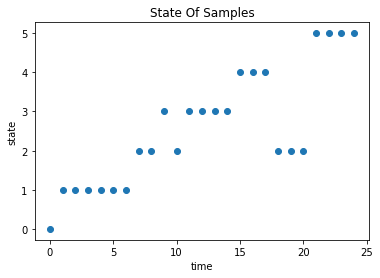

In [9]:
ser_y = SER_Y[SER_Y.index.str.contains("\.0")]
ser_y.index = range(len(ser_y))
plt.scatter(ser_y.index, ser_y.values)
plt.ylabel("state")
plt.xlabel("time")
plt.title("State Of Samples")

In [10]:
SAMPLE_DATA = trinary_data.getSampleData()
DF_AM_MDM = SAMPLE_DATA.AM_MDM.T
DF_AW = SAMPLE_DATA.AW.T
DF_GALAGAN = SAMPLE_DATA.galagan.T
DF_SHERMAN = SAMPLE_DATA.sherman.T
DF_RUSTAD = SAMPLE_DATA.rustad.T

In [11]:
DF_AW

,AW_plus_1,AW_neg_1,AW_plus_3,AW_neg_3,AW_plus_4,AW_neg_4
GENE_ID,,,,,,
Rv0117,0,-1,0,0,0,0
Rv3830c,-1,-1,-1,0,-1,0
Rv3082c,-1,-1,-1,-1,-1,-1
Rv1359,-1,-1,-1,-1,-1,-1
Rv2021c,0,0,0,0,0,0
...,...,...,...,...,...,...
Rv1423,0,-1,0,0,-1,0
Rv3855,-1,0,-1,0,0,-1
Rv3557c,0,-1,0,0,-1,0


## Helper Functions

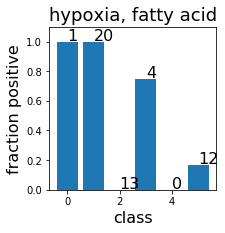

In [12]:
def fullProfile(ser_X, title="", terms=["hypoxia", "fatty acid"], **kwargs):
    """
    Creates a classification profile for the feature vector.

    Parameters
    ----------
    ser_X: Series (feature vector)
    
    Returns
    -------
    pd.DataFrame
        columns: class
        index: FeatureVector
        values: num_zero
    """
    feature_vector = FeatureVector.make(ser_X)
    if terms is None:
        multi= CASE_MULTI_COLLECTION
    else:
        multi = CASE_MULTI_COLLECTION.select(CaseCollection.selectByDescription, ser_desc=SER_DESC, terms=terms)
    df = multi.plotBars(feature_vector=feature_vector, title=title, **kwargs)
# TESTING
ser_X = DF_X.loc["T2.1"]
terms = ["hypoxia", "fatty acid"]
fullProfile(ser_X, figsize=(3,3), terms=["hypoxia"], title=", ".join(terms))

In [13]:
DF_AW.head(2)

,AW_plus_1,AW_neg_1,AW_plus_3,AW_neg_3,AW_plus_4,AW_neg_4
GENE_ID,,,,,,
Rv0117,0,-1,0,0,0,0
Rv3830c,-1,-1,-1,0,-1,0


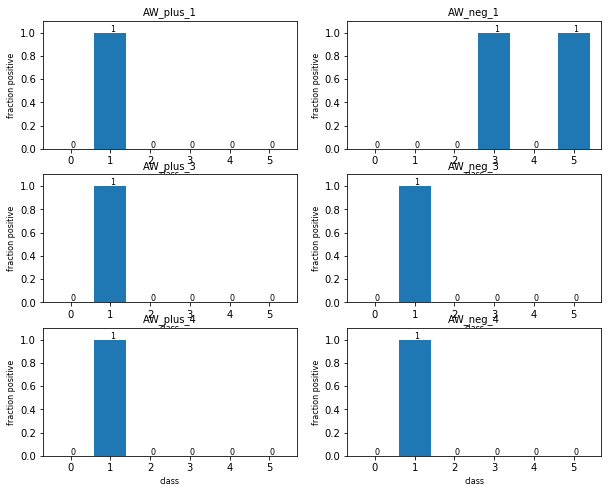

In [14]:
def profile(df, num_row, num_col, is_plot=True, figsize=(10, 8), **kwargs):
    """
    Positive cases for instances.
    
    df: pd.DataFrame
        columns: instances
        rows: genes
    """
    df = df.T
    indices = list(df.index)
    fig, axes = plt.subplots(num_row, num_col, figsize=figsize)
    for irow in range(num_row):
        for icol in range(num_col):
            ax = axes[irow][icol]
            idx = irow*num_col + icol
            instance = indices[idx]
            feature_vector = FeatureVector(df.loc[instance, :])
            CASE_MULTI_COLLECTION.plotBars(feature_vector=feature_vector, is_plot=False,
                                           title=instance, fontsize=8, ax=ax, **kwargs)
    if not is_plot:
        plt.close()
    
# Tests
profile(DF_AW, 3, 2, max_sl=0.0001, is_plot=True)

# Naive Bayes With Genes as Features

In [21]:
values = DF_X.loc["T1.0"].values
test_vector = np.reshape(values, (1, len(values)))

In [31]:
df_X = DF_X + 1
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(df_X, SER_Y)
clf.score(df_X.values, SER_Y)

0.49333333333333335

In [33]:
np.shape(clf.coef_)

(6, 2342)

# NB With Feature Selection

Use same feature selection as with SVM

# Evaluations of Training Data

In [15]:
{STATE_DCT[k]: len(c) for k, c in CASE_MULTI_COLLECTION.collection_dct.items()}

{'Normoxia': 7,
 'Transition': 1883,
 'Stage II': 6932,
 'Stage 1a': 3106,
 'Stage 1b': 274,
 'Resuscitation': 7587}

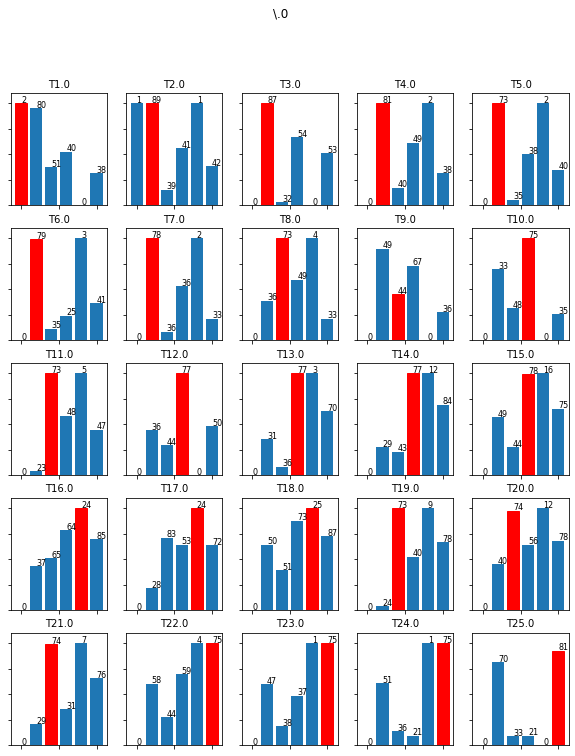

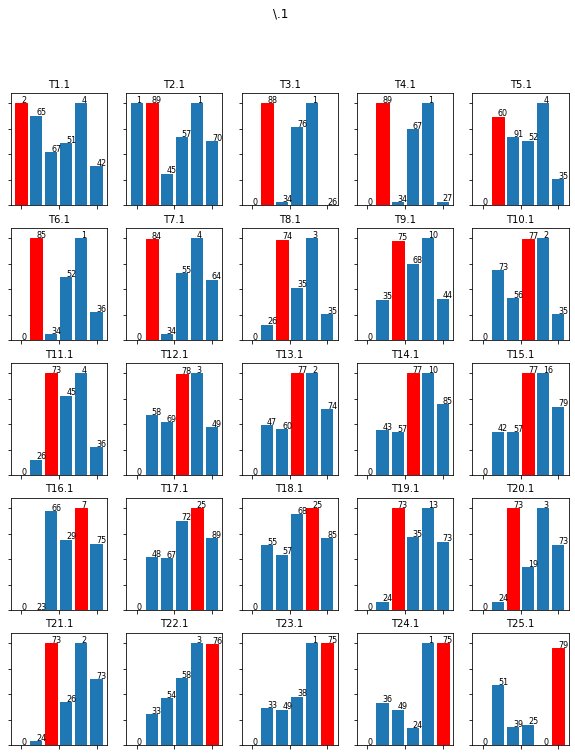

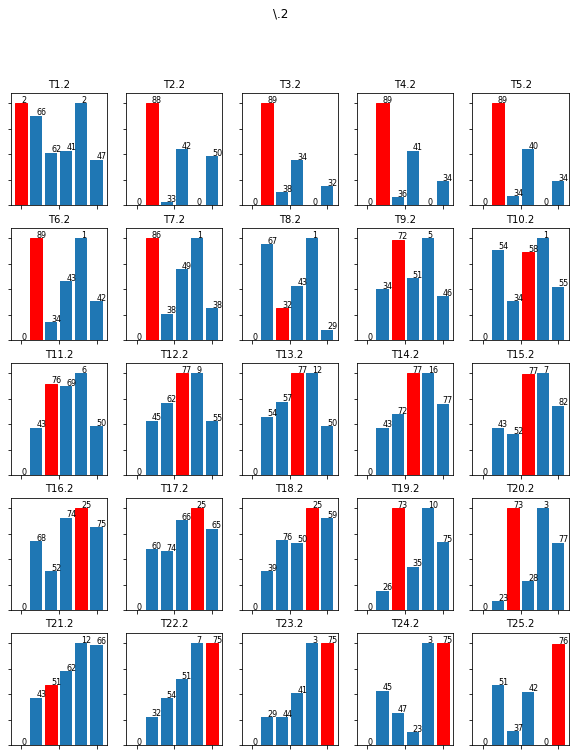

In [16]:
for rep in ["\.0", "\.1", "\.2"]:
    df = DF_X[DF_X.index.str.contains(rep)]
    CASE_MULTI_COLLECTION.plotBarsForFeatures(df, 5, 5, suptitle = rep, ser_y=SER_Y, fontsize=8, max_sl=0.001)

# Other Data Sets

## AW

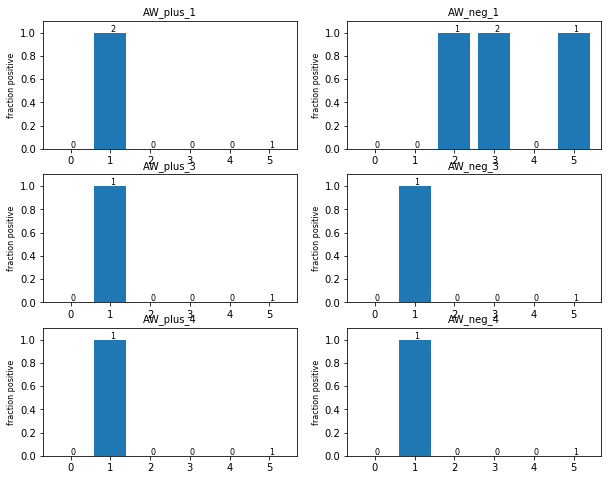

In [17]:
profile(DF_AW, 3, 2, max_sl=0.005, xlabel="")

## AM, MDM

In [18]:
df = DF_AM_MDM.T
df

GENE_ID,Rv0117,Rv3830c,Rv3082c,Rv1359,Rv2021c,Rv1674c,Rv0158,Rv0880,Rv2745c,Rv1379,...,Rv1675c,Rv3173c,Rv3219,Rv0232,Rv1049,Rv1423,Rv3855,Rv3557c,Rv2760c,Rv0330c
AM_D20_1,-1,-1,-1,-1,0,-1,0,-1,-1,-1,...,-1,0,0,0,-1,0,-1,0,-1,-1
AM_D20_3,0,-1,-1,-1,0,-1,0,-1,-1,-1,...,-1,0,0,0,-1,0,0,0,-1,-1
AM_D20_4,0,0,-1,0,0,-1,-1,-1,-1,-1,...,0,0,0,0,-1,-1,0,0,-1,-1
AM_D20_5,-1,-1,0,0,-1,0,0,-1,-1,-1,...,-1,0,0,0,-1,0,0,1,-1,-1
MDM_D20_1,0,-1,-1,0,1,0,0,-1,-1,-1,...,-1,0,-1,0,-1,-1,-1,0,0,-1
MDM_D20_3,0,0,-1,-1,1,0,0,-1,-1,-1,...,0,0,0,0,-1,0,-1,0,-1,-1
MDM_D20_4,0,0,-1,-1,0,-1,0,-1,0,-1,...,-1,0,0,0,-1,0,0,0,-1,-1
MDM_D20_5,1,-1,-1,-1,1,-1,-1,-1,0,-1,...,-1,0,0,0,-1,-1,0,1,-1,-1


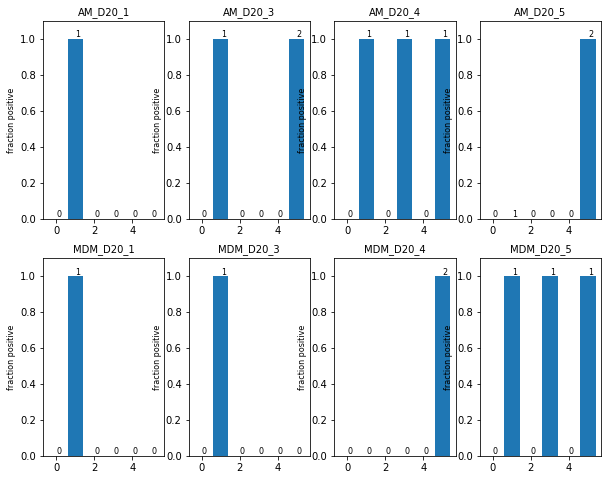

In [19]:
profile(DF_AM_MDM, 2, 4, max_sl=1e-4, xlabel="")

## Galagan

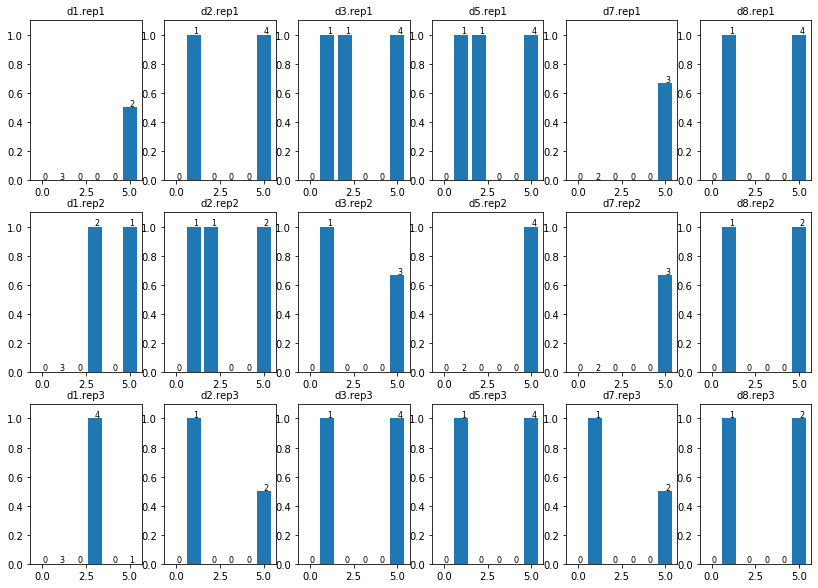

In [20]:
profile(DF_GALAGAN, 3, 6, figsize=(14, 10), max_sl=1e-3, xlabel="", ylabel="")

## Sherman

TypeError: 'AxesSubplot' object does not support indexing

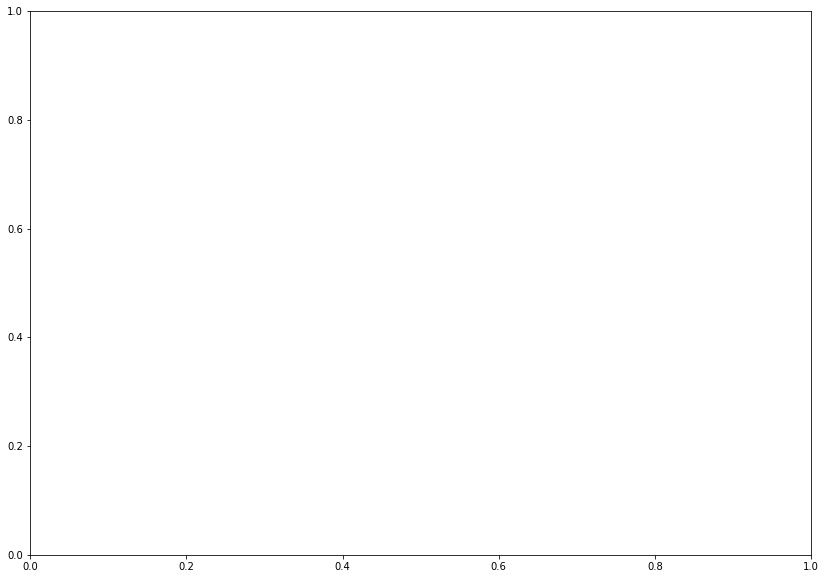

In [21]:
profile(DF_SHERMAN, 1, 1, figsize=(14, 10), max_sl=0.05, xlabel="", ylabel="")

In [ ]:
DF_SHERMAN

## Rustad

In [ ]:
DF_RUSTAD.head(2)

In [ ]:
for instance in DF_RUSTAD.columns:
    fullProfile(DF_RUSTAD[instance], title=instance)

# Evaluations of Samples - Only "hypoxia"

In [ ]:
CASE_MANAGER_DCT = copy.deepcopy(CASE_MANAGER_BASE_DCT)

In [ ]:
[m.filterCaseByDescription(SER_DESC, include_terms=["hypoxia"]) for m in CASE_MANAGER_DCT.values()]
{k: len(CASE_MANAGER_DCT[k].case_dct) for k in CASE_MANAGER_DCT}

## Training Data

In [ ]:
# Below is a evaluation of the feature vector at the first replication at time T3.
instances = ["T3.0", "T3.1", "T3.2"]
for instance in instances:
    fullProfile(DF_X.loc[instance], title=instance)

In [ ]:
instances = ["T13.0", "T13.1", "T13.2"]
for instance in instances:
    fullProfile(DF_X.loc[instance], title=instance)
print("State: %s" % STATE_DCT[SER_Y.loc["T13.0"]])

## AW

In [ ]:
instances = [ ["AW_%s_%d" % (pm, n) for pm in ["plus", "neg"]] for n in [1, 3, 4]]
instances = list(np.array(instances).flatten())
for instance in instances:
    fullProfile(DF_AW[instance], title=instance)

## AM, MDM

In [ ]:
instances = [ ["%s_D20_%d" % (pm, n) for pm in ["AM", "MDM"]] for n in [1, 3, 4, 5]]
instances = list(np.array(instances).flatten())
for instance in instances:
    fullProfile(DF_AM_MDM[instance], title=instance)

# Next Steps

1. Use other criteria to select the cases
   1. Prefer longer feature vectors since more specific
   1. Remove correlated cases
   1. Filter feature vectors?
   1. Evaluate using counts of pos/neg cases by class